In [1]:
# Standard lib
import sys
import glob
                
import numpy as np
from numpy import ma
import matplotlib.pyplot as plt


from matplotlib.ticker import ScalarFormatter
import geopandas as gpd
from shapely.geometry import Point

import seaborn as sns
# Adjust plot font sizes
sns.set(font_scale=1.5)
sns.set_style("white")


import pandas as pd

from sklearn import preprocessing
from sklearn.decomposition import pca

from mpl_toolkits.basemap import Basemap as bm

import netCDF4 as nc

In [2]:
# Set path to RCM data
PATH = './data/pr_24hr_50yrs/'
PATH_SUP = './support/'

In [3]:
# Create a list of all files in PATH
nc_list = np.asarray(glob.glob(PATH+"*"))

In [4]:
# Create a list of Dataset objects using netCDF4
dataset_list = np.asarray([nc.Dataset(path) for path in nc_list])

In [5]:
dataset_list.shape, nc_list.shape

((35,), (35,))

In [6]:
# Choose one random instance
# -------------------------- #
indx = np.random.randint(0, dataset_list.shape[0])
inst = dataset_list[indx]

In [7]:
inst['pr']

<class 'netCDF4._netCDF4.Variable'>
float64 pr(rlat, rlon)
    units: mm h-1
    _FillValue: nan
    long_name: 50-year 24-hour precipitation flux
unlimited dimensions: 
current shape = (124, 149)
filling on

In [8]:
inst['lat']

<class 'netCDF4._netCDF4.Variable'>
float64 lat(rlat, rlon)
    units: degrees_north
    _FillValue: nan
    long_name: latitude
unlimited dimensions: 
current shape = (124, 149)
filling on

In [9]:
rlat = inst.variables['rlat'][:]
rlon = inst.variables['rlon'][:]
print('rlat', rlat.shape, 'rlon', rlon.shape)

rlat (124,) rlon (149,)


In [10]:
# Create list of parameters in dataset list
lat = [full.variables['lat'][:, :] for full in dataset_list]
lon = [full.variables['lon'][:, :] for full in dataset_list]
pr = [full.variables['pr'][:, :] for full in dataset_list]

# Construct 3D pandas dataframe with each data
# file as a layer in the 3rd dimension
pr={}
for full in dataset_list:
    pr[full] = full.variables['pr'][:, :]

df_pr = pd.Panel(pr)

# Create tuple of 3d df and rotated lat/lon
CanRCM4 = {'df_pr': df_pr, 
           'rlat': rlat, 
           'rlon': rlon
          }

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3267: FutureWarning: 
Panel is deprecated and will be removed in a future version.
The recommended way to represent these types of 3-dimensional data are with a MultiIndex on a DataFrame, via the Panel.to_frame() method
Alternatively, you can use the xarray package http://xarray.pydata.org/en/stable/.
Pandas provides a `.to_xarray()` method to help automate this conversion.

  exec(code_obj, self.user_global_ns, self.user_ns)


In [11]:
dfx = CanRCM4['df_pr'][dataset_list[1]].T

prx = {'pr': dfx.values.flatten(),
       'rlon': np.tile(CanRCM4['rlon'], len(rlat)),
       'rlat': np.tile(CanRCM4['rlat'], len(rlon))
      }

idx = np.argwhere(~np.isnan(prx['pr']))[:,0]

print(prx['pr'][idx])

prx_maskd = {'pr': prx['pr'][idx],
            'rlon': prx['rlon'][idx],
            'rlat': prx['rlat'][idx]
            }

[2.62967844 2.34698278 2.55407072 ... 1.59810338 1.66034745 1.49151918]


In [12]:
df_prx = pd.DataFrame.from_dict(prx_maskd).sample(frac=0.02)

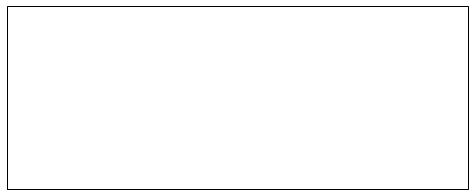

In [19]:
from cartopy import crs
import matplotlib.pyplot as plt

cart = crs.RotatedPole(pole_longitude=180.0, 
                       pole_latitude=42.5,
                       central_rotated_longitude=-97.0, 
                       globe = crs.Globe(semimajor_axis=6370000,
                                semiminor_axis=6370000))

fig = plt.figure(figsize=(8,8))
ax = plt.axes([0.1,0.1,0.8,0.8], projection=cart)
ax.set_extent([-139.08585, 22.661009, -10.590603, 46.591976], crs.Geodetic())
plt.show()

In [14]:
class MapXtremePCIC:
    """ 
    MapXtremePCIC maps design values over North America
    ====================================================
    Arguments
     CanRCM4.lens : information data list for CanRCM4 modelled design values over North America
     obs : data array of observed design values over North America, [lon, lat, data] three columns 
     res : resolution (in km) of the map
     method : whether EOF or SOM-based method is employed for mapping
     
    Value
     rlon : vector of longitude coordinates of the map
     rlat : vector of latitude coordinates of the map
     xtreme : data array of the mapped design values
     sp.basis : data array of the spatial basis functions estimated from CanRCM4 modelled data
     obs.grid : data array of the gridded observations 
    
    Note: the coordinate system is in polar rotated projection for all involved arrays. The projection
     is "+proj=ob_tran +o_proj=longlat +lon_0=-97 +o_lat_p=42.5 +a=1 +to_meter=0.0174532925199 +no_defs"
     
    Author : Nic Annau at PCIC, University of Victoria, nannau@uvic.ca
    """

    def __init__(self, CanRCM4, obs, res, method):
        
        self.CanRCM4 = CanRCM4
        self.obs = obs
        self.res = res
        self.method = method
        
        if (type(method) != type('string')):
            raise ValueError('Method argument requires {} got {}'.format(type('string'), type(method)))
        if (method != 'eof' and method != 'som'):
            raise Exception('MapXtremePCIC requires specified \'som\' or \'eof\'. Got {}'.format(method))
        
        if (obs.shape[0] < 100):
            raise Exception('Observed design values sample size of {} is too small (<100).'.format(obs.shape[0]))

        
        # Set default res if not specified
        if (res == None):
            print("Res not specified. Setting default res = 50.")
            self.res = 50
        
        # Check map resolution    
        if (type(res) != type(1)):
            raise ValueError('Mapping resolution requires {}, got {}'.format(type(1), type(res)))
        
        # Finds closest value to res in array
        resLibrary = [50, 25, 10, 5, 1]
        resLib = resLibrary[np.argmin(np.abs(np.subtract(res, res_library)))]
        resFactor = resLib/res

        #method <- match.arg(method)

        # organize (35) maps to (35) vectors
        xtreme = np.asarray(CanRCM4['df_pr'])
        rlon = CanRCM4['rlon']
        rlat = CanRCM4['rlat']

        # Get dimensions of input
        xtreme_dim = xtreme.shape
        nrlon = rlon.shape[0]
        nrlat = rlat.shape[0]
        nrun = xtreme.shape[0] # Number of files
                
        # initialize empty array
        xtremeMatrix = np.zeros((nrun, nrlon*nrlat))
        
        # Sklearn prep
        lons, lats = np.meshgrid(rlon, rlat)
        X = np.reshape(xtreme, (xtreme.shape[0], nrlat * nrlon), order='F')
        X = ma.masked_array(X, np.isnan(X))
        ocean = X.sum(0).mask
        land = ~ocean
        X = X[:, land]
        self.X = X
        scaler  = preprocessing.StandardScaler()
        scaler_sst = scaler.fit(X)
        
        X = scaler_sst.transform(X)
        self.x_mean = X.mean()
        self.x_std = X.std()

        skpca = pca.PCA()
        skpca.fit(X)
        
        # Number of PC to explain 70% of variance
        ipc = np.where(skpca.explained_variance_ratio_.cumsum() >= 0.90)[0][0]
        
        PCs = skpca.transform(X)
        EOFs = skpca.components_
        EOFs = EOFs[:ipc,:]
        self.eof_shape = EOFs.shape

        EOF_recons = np.ones((ipc, len(rlat) * len(rlon))) * -999.
        for i in range(ipc): 
            EOF_recons[i,land] = EOFs[i,:] 
        
        EOF_recons.shape
        
        
        m = bm(projection='cyl',llcrnrlat=rlat.min(),urcrnrlat=rlat.max(), \
               llcrnrlon=rlon.min(),urcrnrlon=rlon.max(), \
               lat_ts=0,resolution='c')
        
        cart = crs.RotatedPole(pole_longitude=180.0, 
                        pole_latitude=42.5,
                        central_rotated_longitude=-97.0, 
                        globe = crs.Globe(semimajor_axis=6370000,
                        semiminor_axis=6370000))

        EOF_recons *= 100
        
        m.etopo(scale=0.5, alpha=0.5)
        
        
        #if (method=="eof") {
        #sp.basis <- t(svd(xtreme.matrix)$v[, 1:4])
        #} else {
        #sp.basis <- getCodes(som(X=xtreme.matrix, grid=somgrid(2, 2, "hexagonal", "gaussian"), rlen=10000, keep.data=FALSE))
        #}

        # create the mapping grid
        #num.map.rlon <- res.factor*num.rlon
        #num.map.rlat <- res.factor*num.rlat
        #map.rlon <- seq(from=min(rlon), to=max(rlon), length.out=num.map.rlon)
        #map.rlat <- seq(from=min(rlat), to=max(rlat), length.out=num.map.rlat)

        # interpolate the spatial basis function
        #map.sp.basis <- array(NA, dim=c(num.map.rlon, num.map.rlat, 4))
        #for (i in 1:4) {
        #map.sp.basis[, , i] <- interp(x=rlon.matrix, y=rlat.matrix, z=sp.basis[i, ], xo=map.rlon, yo=map.rlat, extrap=TRUE)$z
        #}

        # mask oceans in the mapping grid
        #mask <- land.mask(map.rlon, map.rlat)
        #mask <- replicate(4, mask, simplify=FALSE)
        #mask <- do.call(abind, c(mask, along = 3))

        #map.sp.basis[!mask] <- NA

        # create gridded observations
        #dif.map.rlon <- (map.rlon[2]-map.rlon[1])*0.5
        #dif.map.rlat <- (map.rlat[2]-map.rlat[1])*0.5

        #obs.grid <- array(NA, dim=c(num.map.rlon, num.map.rlat))
        #for (i in 1:num.map.rlon) {
        #for (j in 1:num.map.rlat) {
        #  if (mask[i, j, 1]) {
        #    idx1 <- obs[, 1]>=(map.rlon[i]-dif.map.rlon) & obs[, 1]<(map.rlon[i]+dif.map.rlon)
        #    idx2 <- obs[, 2]>=(map.rlat[j]-dif.map.rlat) & obs[, 2]<(map.rlat[j]+dif.map.rlat)
        #    obs.grid[i, j] <- mean(obs[idx1&idx2, 3])
        #  }
        #}
        #}
        # Note:
        # The grid value is the mean of the observations falling in a grid cell.

        # estimate 'temporal' basis function
        #idx <- is.na(obs.grid)
        #y <- as.matrix(obs.grid[!idx])
        #x <- array(NA, dim=c(length(y), 4))
        #for (i in 1:4) {
        #x.ith <- map.sp.basis[, , i]
        #x[, i] <- x.ith[!idx]
        #}
        #map.tp.basis <- lm(y~x+1)$coefficients

        # mapping
        #map.xtreme <- map.tp.basis[1]
        #for (i in 1:4) {
        #map.xtreme <- map.xtreme+map.sp.basis[, , i]*map.tp.basis[i+1]
        #}

        # output
        #return(list(rlon=map.rlon,
        #          rlat=map.rlat,
        #          xtreme=map.xtreme,
        #          sp.basis=map.sp.basis,
        #          obs.grid=obs.grid))
        



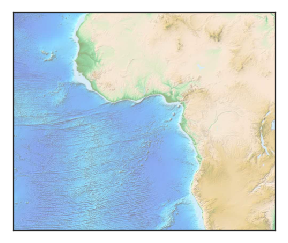

In [15]:
res = 50
method = 'som'
res_library = [50, 25, 10, 5, 1]

xtreme = CanRCM4['df_pr']

rlon = CanRCM4['rlon']

mappy = MapXtremePCIC(CanRCM4, df_prx, res, method)

In [16]:
def landMask(lon, lat):
    """
    Creates land mask for North America
    Arguments
     lon : vector of longitude coordinates for making the land mask
     lat : vector of latitude coordinates for making the land mask
    Returns
     Value: a matrix with TRUE for land grid cells
    """
    nlon = len(lon)

    # all grid cells
    lon = np.tile(lon, len(lat))
    lat = np.tile(lat, len(lon))

    d = {'lon': lon,
         'lat': lat
        }

    pts = pd.DataFrame.from_dict(d)

    # pts.idx <- rownames(pts)

    # grid cells over land

    namCoastShp = coastlineCanRCM4() # Need to write this function

    worldBound = gpd.read_file(landPath)

    #pointList = [Point()]
    """
    coordinates(pts) <- ~lon+lat
    projection(pts) <- proj4string(nam.coast.shp)
    pts.land <- pts[!is.na(over(pts, as(nam.coast.shp, "SpatialPolygons"))),]
    pts.land <- data.frame(pts.land@coords)

    # where are the land grid cells 
    mask <- pts.idx %in% rownames(pts.land)

    # format as a matrix
    mask <- matrix(mask, nrow=num.lon, byrow=TRUE)
    """
    return()

In [17]:
def plot_field(m, X, lats, lons, vmin, vmax, step, cmap=plt.get_cmap('jet'), \
               ax=False, title=False, grid=False):
    if not ax: 
        f, ax = plt.subplots(figsize=(8, (X.shape[0] / float(X.shape[1])) * 8))
    m.ax = ax
    im = m.contourf(lons, lats, X, np.arange(vmin, vmax+step, step), \
                    latlon=True, cmap=cmap, extend='both', ax=ax)
    m.drawcoastlines()
    if grid: 
        m.drawmeridians(np.arange(0, 360, 30), labels=[0,0,0,1])
        m.drawparallels(np.arange(-80, 80, 20), labels=[1,0,0,0])
    m.colorbar(im)
    if title: 
        ax.set_title(title)

In [18]:
################

# Snippet from earlier...

################
# flatten the rlon and rlat into one column for each file
        xtremeMatrix = np.asarray([xtreme[i, :, :].T.flatten() for i in range(nrun)])
        
        # Copies of array with replicates of _m
        rlonMatrix = np.tile(rlon, nrlat)
        rlatMatrix = np.tile(rlat, nrlon)
        
        # Indexes of NaN
        idx = np.argwhere(~np.isnan(xtremeMatrix))
        idxx = idx[:, 0]
        idxy = idx[:, 1]
        
        # Mask grid cells with missing values, e.g., oceans
        self.xtremeMatrix = xtremeMatrix[:, ~np.isnan(xtremeMatrix).any(axis=0)]
        self.rlonMatrix = rlonMatrix[~np.isnan(xtremeMatrix).any(axis=0)]
        self.rlatMatrix = rlatMatrix[~np.isnan(xtremeMatrix).any(axis=0)]

        # Spatial basis function
        if (method == 'eof'):
            # create a solver class, taking advantage of built-in weighting
            solver = Eof(xtremeMatrix, weights='coslat')

            # retrieve the first two EOFs from the solver class
            eofs = solver.eofs(neofs=2)


NameError: name 'nrun' is not defined